In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal, interpolate
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error

from data_loader import load_pickle, unpack_data
sns.set()

N_SUBJECTS = 5

In [2]:
datasets = []
for i in range(1, N_SUBJECTS + 1):
    datasets.append(load_pickle(i))

In [3]:
def compute_distances(Sxx, f_acc, hr, default_val):
    distances = []

    for t in range(Sxx.shape[1]):
        
        # check whether there is a relevant accelerometer frequency at time t
        if sum(Sxx[:, t]) == 0:
            distances.append(default_val)
            continue
        
        # find hr_index that corresponds to a frequency in f_acc that is closest to hr[t]
        hr_index = np.searchsorted(f_acc, hr[t])
        
        # find the distances of all relevant accelerometer freqs to the heart rate freq at time t
        idx_distances_at_t = abs(np.where(Sxx[:, t] == 1)[0] - hr_index)
        distances_at_t = idx_distances_at_t * (f_acc[1] - f_acc[0])
        
        # save the minimum distance at time t
        distances.append(min(distances_at_t))

    return np.array(distances)

<ipython-input-4-c850a9b937a2>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


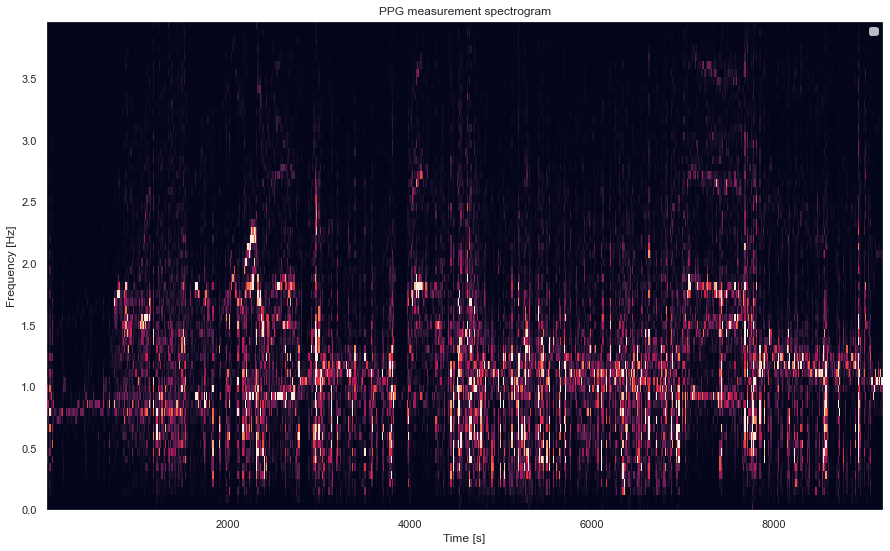

<ipython-input-4-c850a9b937a2>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
<ipython-input-4-c850a9b937a2>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


RMSE: 0.3688434968704137


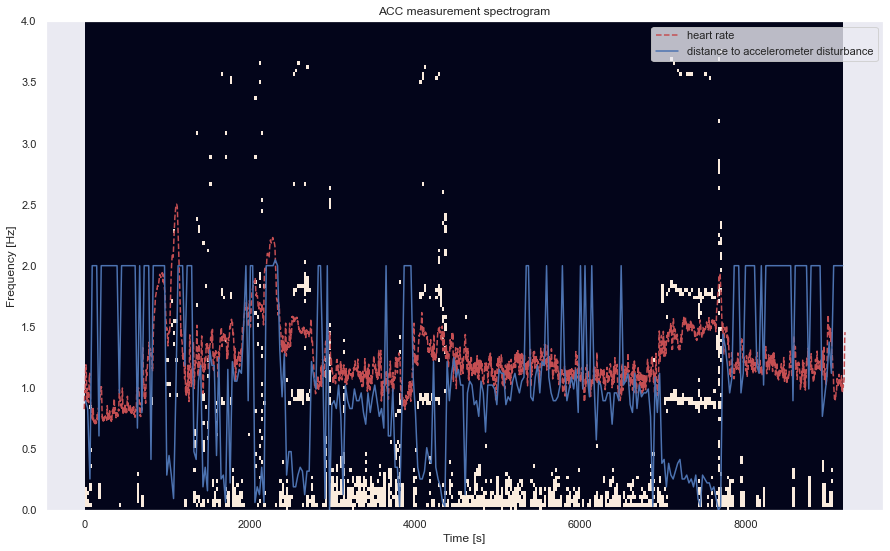

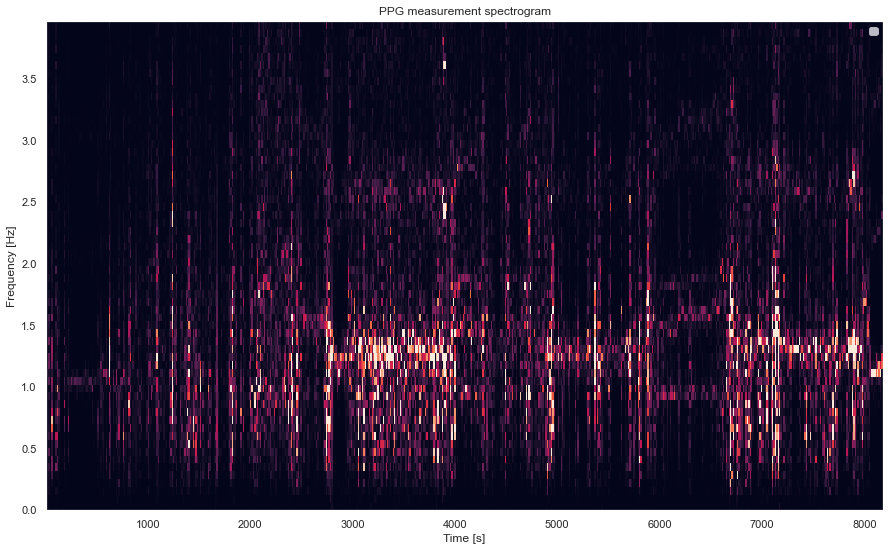

<ipython-input-4-c850a9b937a2>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
<ipython-input-4-c850a9b937a2>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


RMSE: 0.404799049645769


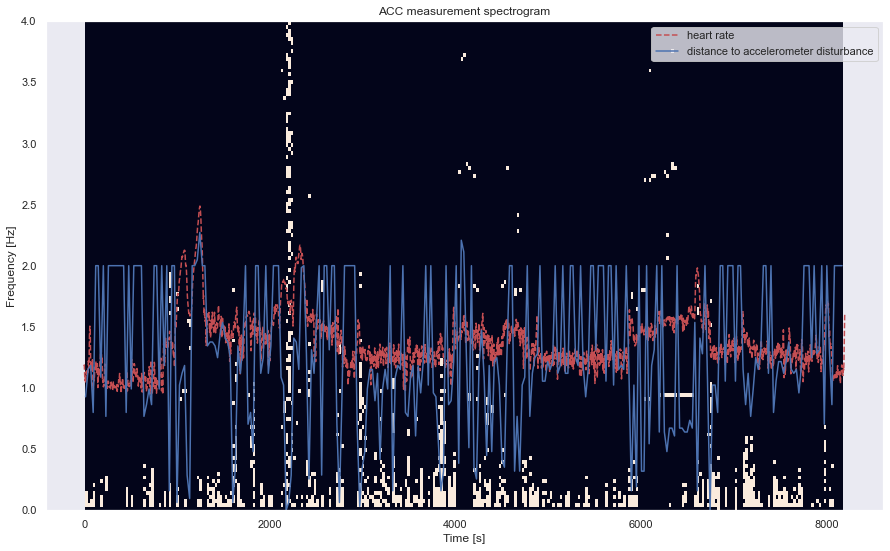

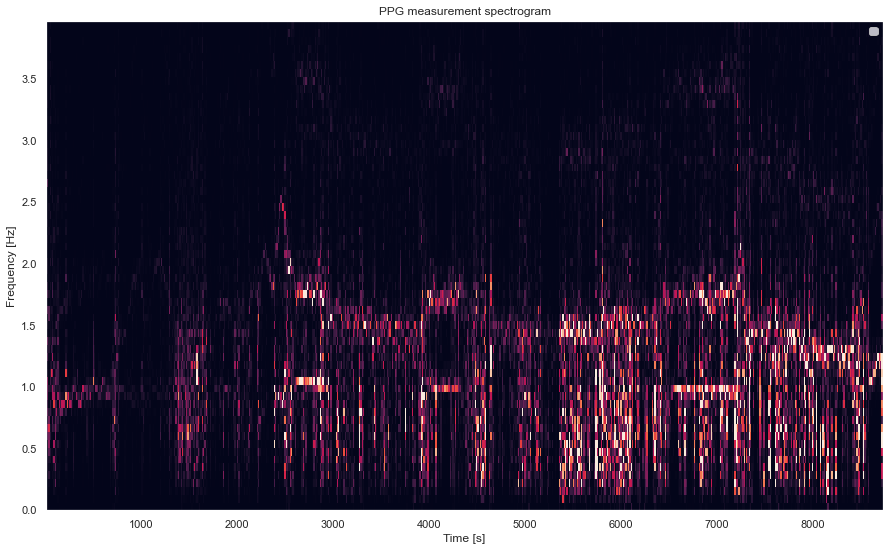

<ipython-input-4-c850a9b937a2>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
<ipython-input-4-c850a9b937a2>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


RMSE: 0.5662615653241578


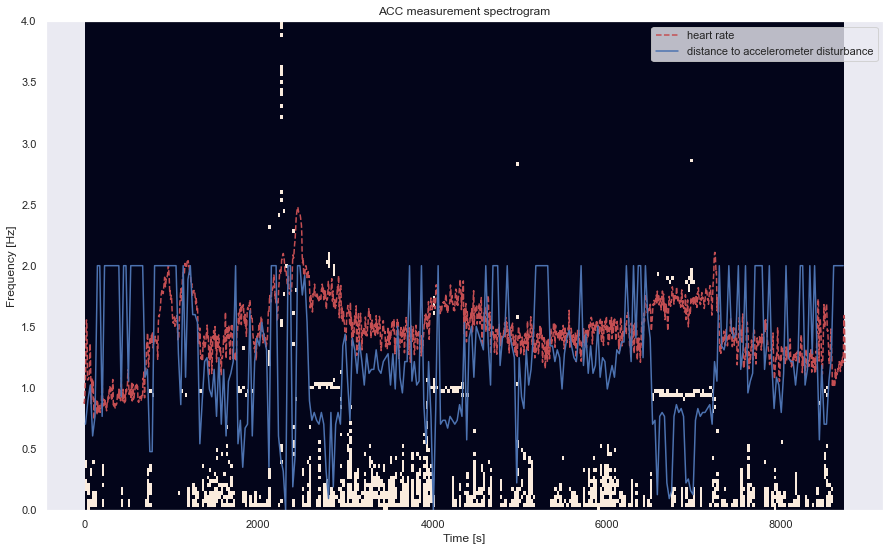

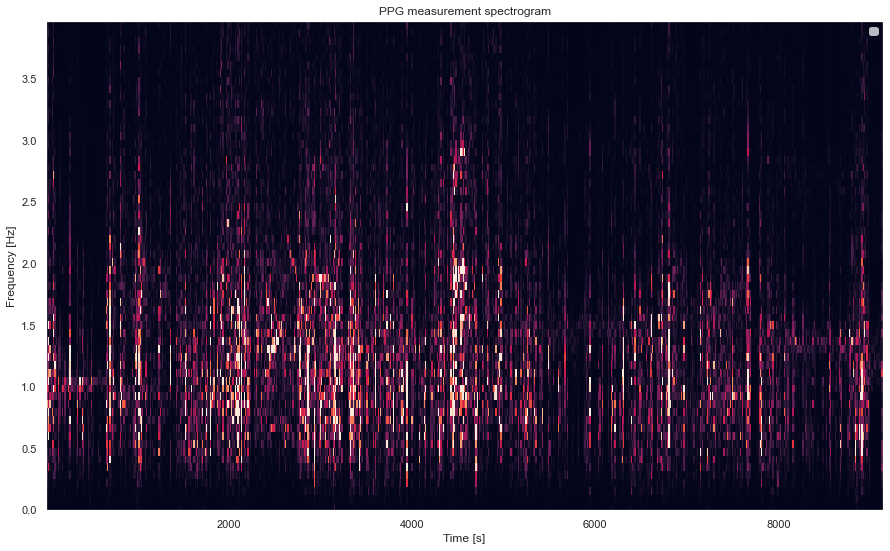

<ipython-input-4-c850a9b937a2>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
<ipython-input-4-c850a9b937a2>:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
No handles with labels found to put in legend.


RMSE: 0.5361344118750052


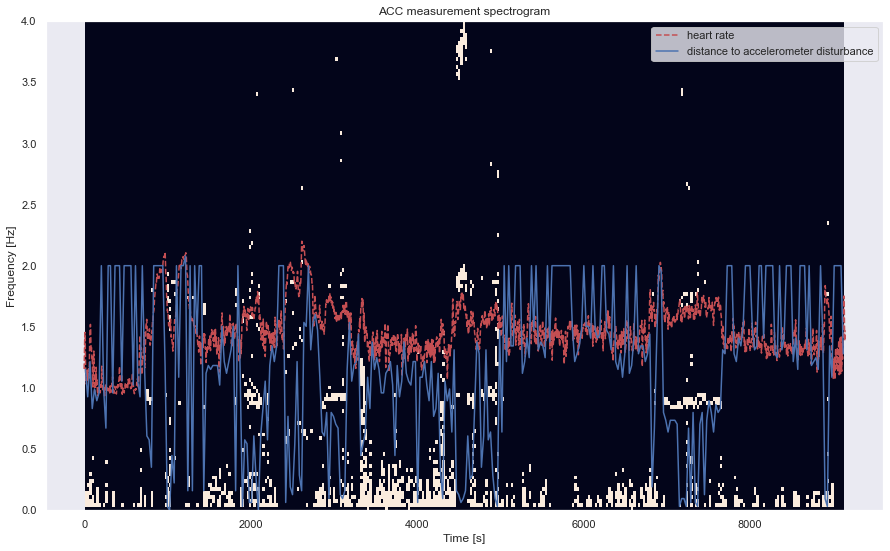

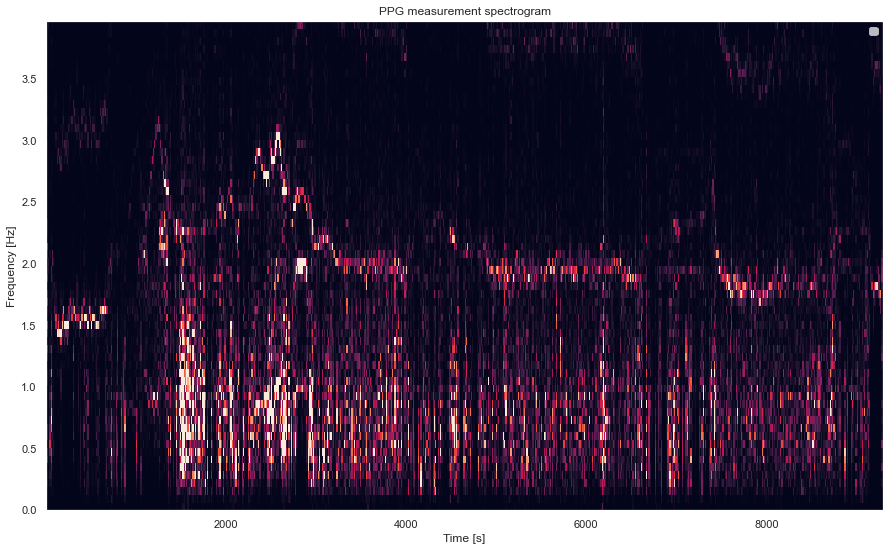

<ipython-input-4-c850a9b937a2>:55: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')


RMSE: 1.13712991195958


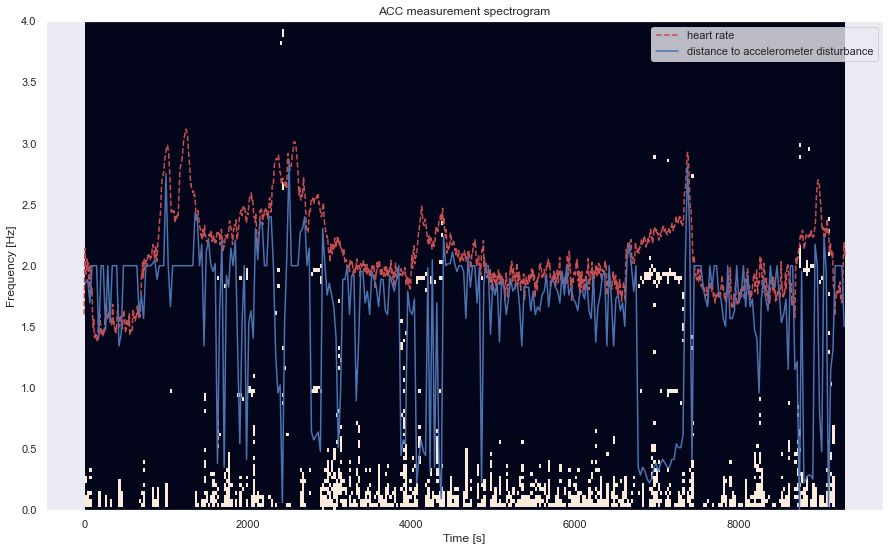

In [4]:
acc_threshold_percentile = 97
distances_default_value = 2

fs_ppg = 64
fs_acc = 32
nperseg_ppg = 1000
noverlap = None

distances_list = []
activity_list = []

for dataset in datasets:

    ppg, acc, hr, activity = unpack_data(dataset)

    hr_timestamps = np.arange(0, len(hr) * 2, 2)
    hr_interpolation = interpolate.interp1d(hr_timestamps, hr)
    
    ### create spectrograms
    f_ppg, t_ppg, Sxx_ppg = signal.spectrogram(ppg, fs_ppg, nperseg=nperseg_ppg, noverlap=noverlap)
    f_acc, t_acc, Sxx_acc = signal.spectrogram(acc, fs_acc, nperseg=nperseg_ppg, noverlap=noverlap)
    
    ### keep only frequencies of interest
    fmin = 0 # Hz
    fmax = 4 # Hz
    freq_slice_ppg = np.where((f_ppg >= fmin) & (f_ppg <= fmax))
    freq_slice_acc = np.where((f_acc >= fmin) & (f_acc <= fmax))
    f_ppg = f_ppg[freq_slice_ppg]
    f_acc = f_acc[freq_slice_acc]
    Sxx_ppg = Sxx_ppg[freq_slice_ppg,:][0]
    Sxx_acc = Sxx_acc[freq_slice_acc,:][0]
    
    ### clip spectrograms
    Sxx_acc_clipped = np.clip(Sxx_acc, 0, np.percentile(Sxx_acc.flatten(), 99))
    Sxx_ppg_clipped = np.clip(Sxx_ppg, 0, np.percentile(Sxx_ppg.flatten(), 99))

    ### plot ppg spectrogram
    plt.figure(figsize=(15, 9))
    plt.pcolormesh(t_ppg, f_ppg, Sxx_ppg_clipped, shading='flat')
    plt.title('PPG measurement spectrogram')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    
    ### plot heart rate
    ppg_estimate = f_ppg[np.argmax(Sxx_ppg, axis=0)]
    #plt.plot(hr_timestamps, hr, 'r--', label='heart rate')
    #plt.plot(t_ppg, ppg_estimate, 'g--', label='ppg heart rate estimate')
    plt.legend()
    plt.show()
    
    ### plot acc spectrogram
    plt.figure(figsize=(15, 9))
    #plt.pcolormesh(t_acc, f_acc, Sxx_acc_clipped, shading='flat')
    Sxx_acc_above_threshold = (Sxx_acc > np.percentile(Sxx_acc.flatten(), acc_threshold_percentile)).astype(int)
    plt.pcolormesh(t_acc, f_acc, Sxx_acc_above_threshold, shading='flat')
    plt.title('ACC measurement spectrogram')
    plt.plot(hr_timestamps, hr, 'r--', label='heart rate')
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [s]')
    
    ### plot distance metric
    hr_at_acc_timestamps = hr_interpolation(t_acc)
    distances = compute_distances(Sxx_acc_above_threshold, f_acc, hr_at_acc_timestamps, distances_default_value)
    plt.plot(t_acc, distances, label='distance to accelerometer disturbance')
    plt.legend()
    
    ### save relevant data
    activity_subsample = activity[(t_acc * 4).astype(int)]
    distances_list.append(distances)
    activity_list.append(activity_subsample)
    
    print('RMSE:', math.sqrt(mean_squared_error(hr_interpolation(t_ppg), ppg_estimate)))


In [5]:
distances_combined = []
activity_combined = []
subject_combined = []

for i in range(len(distances_list)):
    
    distance = distances_list[i]
    activity = activity_list[i]
    
    distances_combined = np.append(distances_combined, distance)
    activity_combined = np.append(activity_combined, activity)
    subject_combined = np.append(subject_combined, [i + 1] * len(distance))
    
    

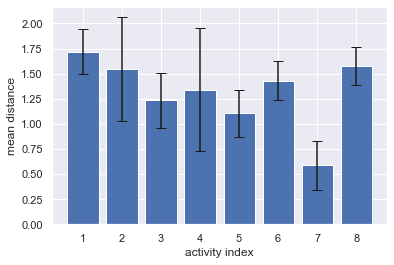

In [6]:
# analyze distances across activities
distance_means = []
distance_stds = []
for i in range(1, 9):
    relevant_distances = distances_combined[activity_combined == i]
    distance_means.append(np.nanmean(relevant_distances))
    distance_stds.append(np.nanvar(relevant_distances))
plt.bar(range(1, 9), distance_means, yerr=distance_stds, capsize=5)
plt.ylabel('mean distance')
plt.xlabel('activity index')
plt.show()

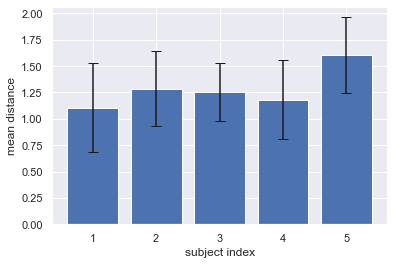

In [7]:
# analyze distances across subjects
distance_means = []
distance_stds = []
for i in range(1, N_SUBJECTS + 1):
    relevant_distances = distances_combined[subject_combined == i]
    distance_means.append(np.nanmean(relevant_distances))
    distance_stds.append(np.nanvar(relevant_distances))
plt.bar(range(1, N_SUBJECTS + 1), distance_means, yerr=distance_stds, capsize=5)
plt.ylabel('mean distance')
plt.xlabel('subject index')
plt.show()